<a href="https://colab.research.google.com/github/maceyworthington/DataScience-GenAI-Submissions/blob/main/5_02_Modelling_Hackathon_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 5.02 Modelling Hackathon
We'll get a chance in this seminar to practice for the in-class test, and also to put what we have learned into practice.

To speed things up, I have done the data/feature engineering for you, you will just need to build it into a data science model. As before, you can use the code from [GitHub](https://github.com/MJMortensonWarwick/IB2AD0_Data_Science_GenerativeAI), from the internet, and/or use the Gemini AI tools.

This is an artificial dataset, and we will be predicting if students achieve a passing grade, which we will call anything above a "D".

We'll start by importing the data:

In [2]:
from google.colab import files
upload = files.upload()

Saving students_two.csv to students_two (1).csv


Now we will get the data into Pandas and inspect it:

In [3]:
import pandas as pd
df = pd.read_csv("students_two.csv")

df.head()

,Id,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,5001,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,5002,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,5003,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,5004,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,5005,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Let's check for missing values:

In [4]:
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,1
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


Only one missing value. Let's just drop it out of laziness:

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,0
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


We have an ID column we know won't be predictive ... so let's drop it:

In [6]:
df = df.drop(["Id"], axis=1)
df.head()

,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Next we will convert some of the text features to numbers:

In [7]:
# High school
print(df['High_School_Type'].unique())

['Other' 'State' 'Private']


We can't easily convert these to a number range. Instead we should use one-hot encoding:

In [8]:
df = pd.get_dummies(df, columns=['High_School_Type'], drop_first=True, dtype=int)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,50%,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


We have converted this to two columns (on the far right) - "High_School_Type_Private" and "High_School_Type_State". We do not need the "Other" type as if the student is "Other" then both "Private" and "State" will be 0 (a unique combination). This is controlled by the command _drop\_first=True_. We also specify the data type (_dtype_) as __int__ so we return 0s and 1s rather than True and False.

Next we can look at Scholarship. It needs to be converted from a text representation of a percentage to a number:

In [9]:
df['Scholarship'] = df['Scholarship'].str.replace('%', '').astype(float) / 100
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


"Additional_Work" is next:

In [10]:
# Additional work
print(df['Additional_Work'].unique())

['Yes' 'No']


Two values, so we can convert to 0 and 1:

In [11]:
df['Additional_Work'] = df['Additional_Work'].map({'Yes': 1, 'No': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Let's speed up now:

In [12]:
categorical_cols = ['Sports_activity', 'Transportation', 'Attendance', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work', 'Grade']

for col in categorical_cols:
    print(f"Unique values for '{col}': {df[col].unique()}")

Unique values for 'Sports_activity': ['No' 'Yes']
Unique values for 'Transportation': ['Private' 'Bus']
Unique values for 'Attendance': ['Always' 'Never' 'Sometimes' '3']
Unique values for 'Reading': ['Yes' 'No']
Unique values for 'Notes': ['Yes' 'No' '6']
Unique values for 'Listening_in_Class': ['No' 'Yes' '6']
Unique values for 'Project_work': ['No' 'Yes']
Unique values for 'Grade': ['AA' 'BA' 'CC' 'Fail' 'BB' 'CB' 'DD' 'DC']


The values of '6' in 'Notes' and 'Listening_in_Class' make no sense, and neither do '3' for 'Attendance'. We'll be lazy and drop these rows (really we should check with an SME):

In [13]:
df = df[(df['Notes'] != '6') & (df['Listening_in_Class'] != '6') & (df['Attendance'] != '3')]
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Now we can convert all those "Yes" / "No" columns to 0 and 1.

In [14]:
binary_cols = ['Sports_activity', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,Private,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,Private,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,Private,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,Bus,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,Bus,12,Always,1,0,1,1,AA,1,0


We can also do this with "Transportation":

In [15]:
df['Transportation'] = df['Transportation'].map({'Private': 1, 'Bus': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,Always,1,0,1,1,AA,1,0


For Attendance an ordinal range makes sense:

In [16]:
df['Attendance'] = df['Attendance'].map({'Never': 0, 'Sometimes': 1, 'Always': 2})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,AA,1,0


This just leaves the target - 'Grade'. To make the problem binary we'll convert 'Fail' and any grade that includes a 'D' as 0 (for fail) and the rest as 1 (pass):

In [17]:
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'Fail' or 'D' in x else 1)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,1,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,1,0


The code has a new function `lambda`. A lambda function in Python is a small, anonymous function. It's defined using the `lambda` keyword and can take any number of arguments, but can only have one expression. The expression is evaluated and returned. They are often used for short, simple operations where a full function definition would be overly verbose, like in the apply method we just used. Although the function is new, the actual mechanics are quite simple. If the data is "Fail" or contains "D" return 0, and else return 1.

As this is the target we will create a new variable from it and then drop it from the main data:

In [18]:
Y_values = df[['Grade']].values.ravel() # change to list

Y_values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1])

In [19]:
X_values = df.drop(['Grade'], axis=1)
X_values.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,0


We can now scale X:

In [20]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data and convert back to DataFrame
X_values = pd.DataFrame(scaler.fit_transform(X_values), columns=X_values.columns)
X_values

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,0.375,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.250,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.375,0.333333,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.000,0.333333,1.0,0.0,0.0,0.166667,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.500,0.333333,0.0,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.500,0.333333,1.0,1.0,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0
136,0.000,0.666667,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
137,0.000,0.666667,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0
138,0.500,0.666667,1.0,1.0,0.0,1.000000,0.5,0.0,1.0,0.0,1.0,0.0,1.0


And now we can split into training and test:

In [21]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2, random_state=1984, stratify=Y_values)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(112, 13)
(28, 13)
(112,)
(28,)


And now its time for modelling ...



Your turn :)

Set up with default hyperparameters to compare performance on the training data

In [23]:
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from xgboost import XGBClassifier as XGB
from sklearn.metrics import precision_recall_fscore_support

LogR_algo = LogR()
LogR_model = LogR_algo.fit(X_train, Y_train)

RF_algo = RF()
RF_model = RF_algo.fit(X_train, Y_train)

GBDT_algo = GBDT()
GBDT_model = GBDT_algo.fit(X_train, Y_train)

XGB_algo = XGB()
XGB_model = XGB_algo.fit(X_train, Y_train)

models = [LogR_model, RF_model, GBDT_model, XGB_model]
names = ['Logistic Regression', 'Random Forest', 'GBDT', 'XGBDT']

for i in range(4):
  print(f"Model: {names[i]}")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.6738317757009346
Macro Recall: 0.5378048780487805
Macro F1-score: 0.508994708994709


Model: Random Forest
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0


Model: GBDT
Macro Precision: 0.9939759036144578
Macro Recall: 0.9833333333333334
Macro F1-score: 0.9884951206985105


Model: XGBDT
Macro Precision: 0.9939759036144578
Macro Recall: 0.9833333333333334
Macro F1-score: 0.9884951206985105




Random Forest scores perfectly, so check for overfitting by tuning the hyperparameters of Random Forest model

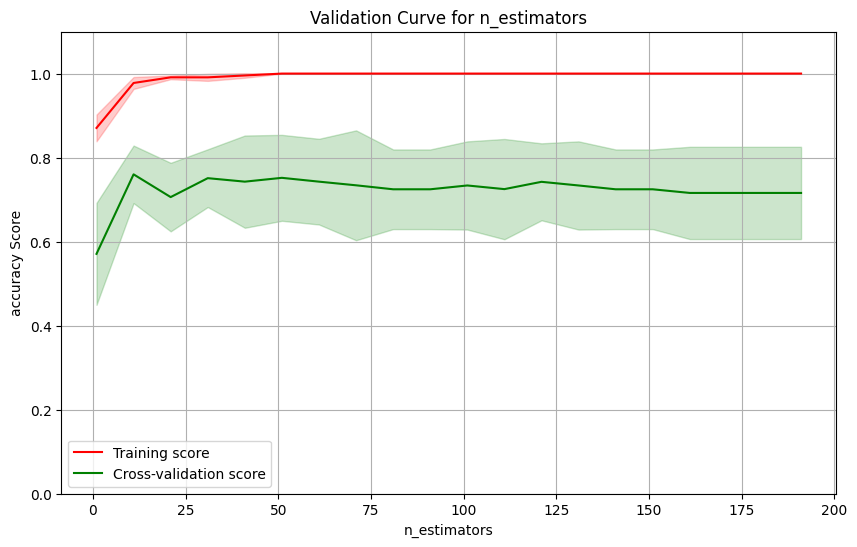

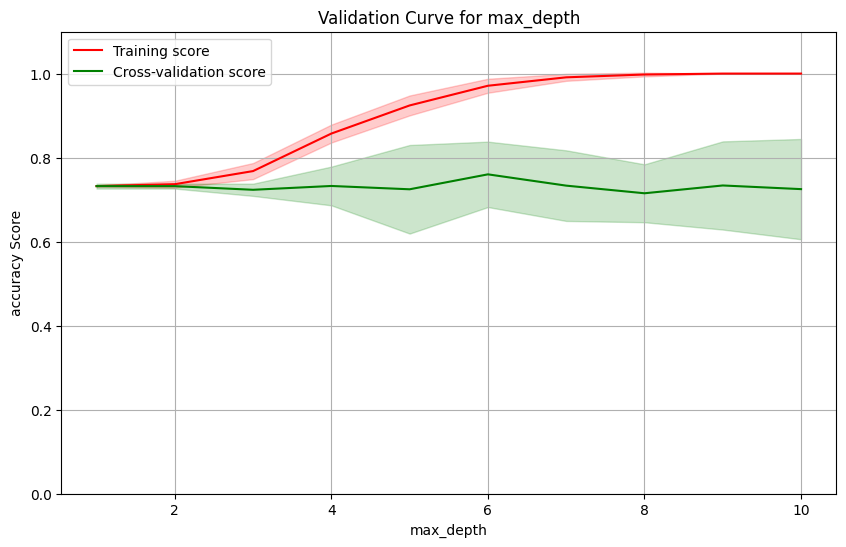

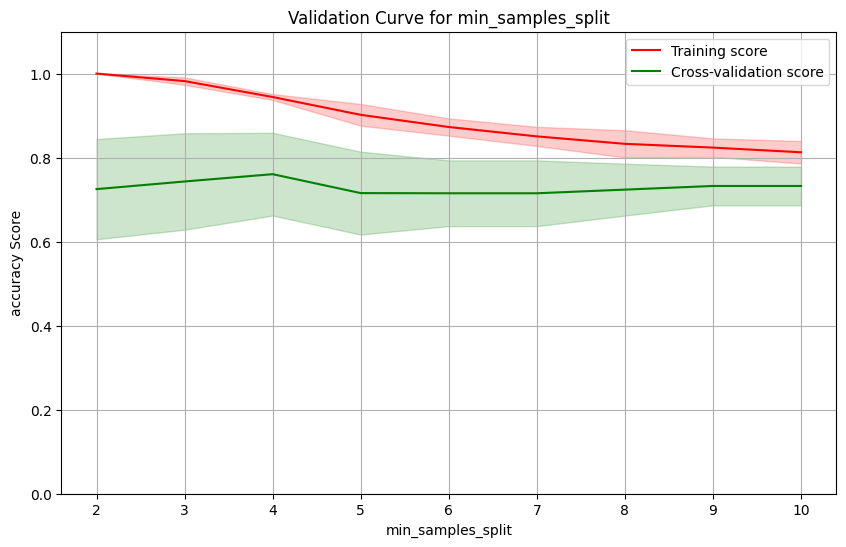

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

def plot_validation_curve(estimator, X, y, param_name, param_range, scoring="accuracy", cv=5, n_jobs=-1):
    """
    Generates and plots a validation curve for a given hyperparameter.

    Args:
        estimator: The model estimator.
        X: Training data.
        y: Target variable.
        param_name: The name of the hyperparameter to tune.
        param_range: The range of hyperparameter values to explore.
        scoring: The scoring metric to use.
        cv: Number of cross-validation folds.
        n_jobs: Number of jobs to run in parallel.
    """
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(f"{scoring} Score")
    plt.ylim(0.0, 1.1)
    plt.plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Define hyperparameter ranges
n_estimators_range = np.arange(1, 201, 10)
max_depth_range = np.arange(1, 11)
max_features_range = ['sqrt', 'log2', None] # Use strings for categorical
min_samples_split_range = np.arange(2, 11)

# Generate validation curves for each hyperparameter
plot_validation_curve(RandomForestClassifier(random_state=1984), X_train, Y_train,
                      param_name="n_estimators", param_range=n_estimators_range)

plot_validation_curve(RandomForestClassifier(random_state=1984), X_train, Y_train,
                      param_name="max_depth", param_range=max_depth_range)

# For categorical hyperparameters, validation_curve requires a list of values and can't plot a continuous range
# We can evaluate them separately or use a different visualization if needed.
# For now, I will skip plotting validation curves for max_features as it's not a numerical range.
# plot_validation_curve(RandomForestClassifier(random_state=1984), X_train, Y_train,
#                       param_name="max_features", param_range=max_features_range)


plot_validation_curve(RandomForestClassifier(random_state=1984), X_train, Y_train,
                      param_name="min_samples_split", param_range=min_samples_split_range)

Using this information, the optimised parameters are below:

In [30]:
print(RF_best_params)

{'max_depth': 6, 'max_features': None, 'min_samples_split': 6, 'n_estimators': 386}


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# we get a load of warnings running the code so will supress them
import warnings
warnings.filterwarnings("ignore")

# create a hyperparameter search function for re-usability
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(algo, hyperparameters, cv=5, random_state=2015,
                          scoring='precision_macro', n_iter=20, refit=True)

  # pass the data to fit/train
  clf.fit(X_train, Y_train)

  return clf.best_params_

# Logistic Regression
LogR_tuned_parameters = {
    'solver': ['liblinear'], # only this one as it does both L1 and L2
    # C is the equivalent of alpha in L1/L2 regression - how much regularisation
    'C': uniform(loc=0.1, scale=19.9),  # Draw from a uniform distribution between 0.1 and 20
    'penalty': ['l1', 'l2', 'elasticnet', None] # elasticnet is a mix of L1 and L2
}

LogR_best_params = random_search(LogR_algo, LogR_tuned_parameters, X_train, Y_train)


# Random Forest
RF_tuned_parameters = {
    'n_estimators': randint(0, 500), # Draw from a uniform distribution between 0 and 500
    'max_depth': randint(2, 7),  # Draw from a uniform distribution between 2 and 7
    'min_samples_split': randint(2, 7),  # Draw from a uniform distribution between 2 and 7
    'max_features': ['sqrt', 'log2', None]
}

RF_best_params = random_search(RF_algo, RF_tuned_parameters, X_train, Y_train)


# GBDT
GBDT_tuned_parameters = {
    'n_estimators': randint(25, 250), # Draw from a uniform distribution between 50 and 500
    'learning_rate': uniform(loc=0.01, scale=4.99),  # Draw from a uniform distribution between 0.01 and 5
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': randint(2, 7)  # Draw from a uniform distribution between 2 and 7
}

GBDT_best_params = random_search(GBDT_algo, GBDT_tuned_parameters, X_train, Y_train)


# XGBDT
XGB_tuned_parameters = {
    'n_estimators': randint(25, 250), # Draw from a uniform distribution between 50 and 500
    # eta is learning rate
    'eta': uniform(loc=0.01, scale=4.99),  # Draw from a uniform distribution between 0.01 and 5
    # objective is the same as criterion
    'objective': ['binary:logistic', 'binary:hinge'],
    'max_depth': randint(2, 7)  # Draw from a uniform distribution between 2 and 7
}

XGB_best_params = random_search(XGB_algo, XGB_tuned_parameters, X_train, Y_train)


# Train the models
LogR_algo = LogR(**LogR_best_params)
LogR_model = LogR_algo.fit(X_train, Y_train)

RF_algo = RF(**RF_best_params)
RF_model = RF_algo.fit(X_train, Y_train)

GBDT_algo = GBDT(**GBDT_best_params)
GBDT_model = GBDT_algo.fit(X_train, Y_train)

XGB_algo = XGB(**XGB_best_params)
XGB_model = XGB_algo.fit(X_train, Y_train)


# score the models
models = [LogR_model, RF_model, GBDT_model, XGB_model] # redo this or it uses the old models

for i in range(len(models)): # for every model in the models list
  print(f"Model: {names[i]}")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.7168284789644013
Macro Recall: 0.5817073170731707
Macro F1-score: 0.5808731808731808


Model: Random Forest
Macro Precision: 0.9272727272727272
Macro Recall: 0.8439024390243902
Macro F1-score: 0.8747763864042934


Model: GBDT
Macro Precision: 0.9615690959776981
Macro Recall: 0.9711382113821139
Macro F1-score: 0.9662073820778436


Model: XGBDT
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0




Score the model on test data

In [27]:
for i in range(4):
  print(f"Model: {names[i]}")

  # predict based on TEST data
  predict = models[i].predict(X_test)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.6190476190476191
Macro Recall: 0.6190476190476191
Macro F1-score: 0.6190476190476191


Model: Random Forest
Macro Precision: 0.553030303030303
Macro Recall: 0.5476190476190477
Macro F1-score: 0.5491949910554561


Model: GBDT
Macro Precision: 0.6432748538011696
Macro Recall: 0.6666666666666666
Macro F1-score: 0.65


Model: XGBDT
Macro Precision: 0.5875
Macro Recall: 0.5952380952380952
Macro F1-score: 0.5902439024390245




Score for preffered metric (macro precision) scores worse for everything.

Random Forest Confusion Matrix


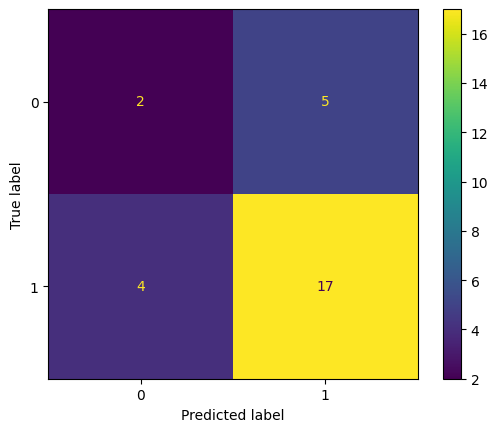

In [28]:

from sklearn.metrics import ConfusionMatrixDisplay as CM

# Random Forest
print("Random Forest Confusion Matrix")
predict = RF_model.predict(X_test)
CM.from_predictions(Y_test, predict)